## Causal Tracing

modify rome repo with `trust_remote_code`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, re, json
import torch, numpy
from collections import defaultdict

from model_utils import *
CACHE_DIR = "/scratch/lucchetti.f/models/"
os.environ['TRANSFORMERS_CACHE'] = CACHE_DIR

import sys
sys.path.append('../codetrace')

DATA_DIR = 'data'
from rome.experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap
)
from rome.experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
    trace_with_patch,
    trace_important_states,
    calculate_hidden_flow
)
from rome.dsets import KnownsDataset

torch.set_grad_enabled(False)

/home/lucchetti.f/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = "bigcode/santacoder"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=True,
    torch_dtype= torch.float32,
    # torch_dtype=(torch.float16 if "20b" in model_name else None),
    trust_remote_code=True
)
## open ai paper GPT-2 -> attention different (open ai CustomGPT2, fill-in middle - santacoder citation) 

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


In [5]:
predict_token(
    mt,
    ['int hello = '],
    return_p=True,
)

(['1'], tensor([0.4089], device='cuda:0', dtype=torch.float16))

In [33]:
check_devs()
mt.model

2353153536 / 34079899648 used for device 0, reserved 2376073216


GPT2LMHeadCustomModel(
  (transformer): GPT2CustomModel(
    (wte): Embedding(49280, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2CustomBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2MQAttention(
          (q_attn): Conv1D()
          (kv_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): FastGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2CustomBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2MQAttention(
          (q_attn): Conv1D()
          (kv_attn): Conv1D()
          (c_proj): C

In [140]:
from rome.util.generate import generate_fast, generate_interactive

prompts = [
    # 'int x = ',
#            'String x = ',
#            'int x =',
#            'String x =',
#            'int hello = ',
#            'String hello = ',
           # 'String thread = '
           # '''a : int = 0; b : int = 1; c : int = ''',
    'def func(x : int): return x +',
    'def func(x : str): return x +',
    'def func(x : str): return x + "',
    'def func(x : int): return x + "',
]
# prompts = ['String hello =']

mt.tokenizer.pad_token = mt.tokenizer.eos_token
# mt.tokenizer.pad_token = " "

# debug = True
text = generate_fast(mt.model, mt.tokenizer, prompts, max_out_len=30)
text

['def func(x : int): return x + ##########\n# # # # # # # # # # # # # # \n#',
 'def func(x : str): return x + "\nifif(funcfuncfuncfuncfuncfuncfuncfuncifif)\nprint(func',
 'def func(x : str): return x + "\ndef func func func func func func func func func func func func func func func func func',
 'def func(x : int): return x + " + + + "\nfuncfuncfuncfuncfunc\n# # # # # # # #']

In [56]:
mt.tokenizer.name_or_path, mt.tokenizer.decode(18533), mt.tokenizer.encode("你")

('bigcode/santacoder', '你', [18533])

In [62]:
mt.tokenizer.decode(19552), mt.tokenizer.encode("线程")

('线程', [19552])

In [71]:
mt.tokenizer.decode(19553)

'⣿'

In [154]:
mt.tokenizer.encode("##########"), mt.tokenizer.encode("#"), mt.tokenizer.encode("##")

([20150], [2], [394])

## Test: relative weight of var name versus type on value prediction

In [36]:
text = generate_interactive(mt.model, mt.tokenizer, 
                            top_k=10, max_out_len=5, 
                            use_logit_lens=True)
text

Enter a prompt:  String hello = 


Argument Model: ['String hello = hello hello']

--- Argument Model Logit Lens ---
0: [(' wtforms', 1), ('herits', 1), (' numba', 1), ('LEAN', 1), ('ARGIN', 1)]
1: [('herits', 1), ('ROWSER', 1), ('LEAN', 1), (' wtforms', 1), ('ometh', 1)]
2: [('ometh', 1), ('ROWSER', 1), ('LEAN', 0), ('ATEG', 0), (' wtforms', 0)]
3: [(' wtforms', 1), ('yscale', 1), ('comes', 0), ('ometh', 0), ('ugment', 0)]
4: [(' "";', 1), (' wtforms', 1), ('null', 1), (' {};', 1), ('new', 0)]
5: [(' "";', 1), ('null', 1), ('рок', 1), (' wtforms', 1), ('new', 1)]
6: [(' "";', 3), ('zstack', 1), ('рок', 1), ('persion', 0), ('null', 0)]
7: [(' "";', 3), ('persion', 1), ('рок', 1), (' [];', 1), ('zstack', 1)]
8: [(' "";', 4), ('persion', 1), ('zstack', 1), (' [];', 1), ('рок', 1)]
9: [(' "";', 5), ('twice', 1), ('zstack', 1), ('ertific', 1), (' [];', 1)]
10: [(' "";', 8), ('zstack', 2), ('twice', 1), ('ertific', 1), (' [];', 1)]
11: [(' "";', 5), ('zstack', 2), ('alwaysUseFieldBuilders', 1), ('ertific', 1), ('LookAnd', 1)

KeyboardInterrupt: Interrupted by user

### Add noise based on dataset of known facts?

In [7]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

Loaded dataset with 2 elements
Using noise level 0.02877044677734375


## Scanning locations + Tracing a single location


In [8]:
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


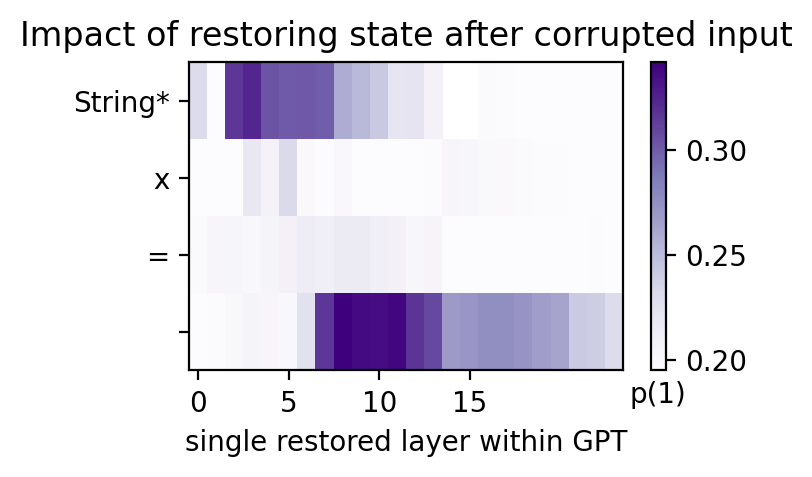

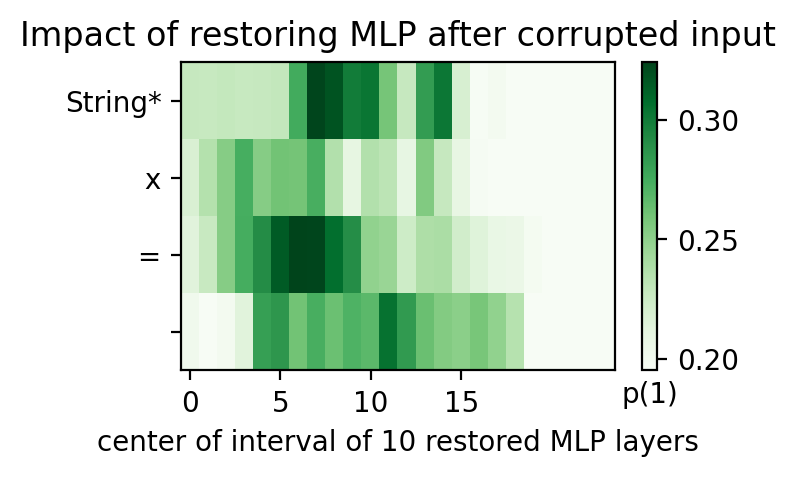

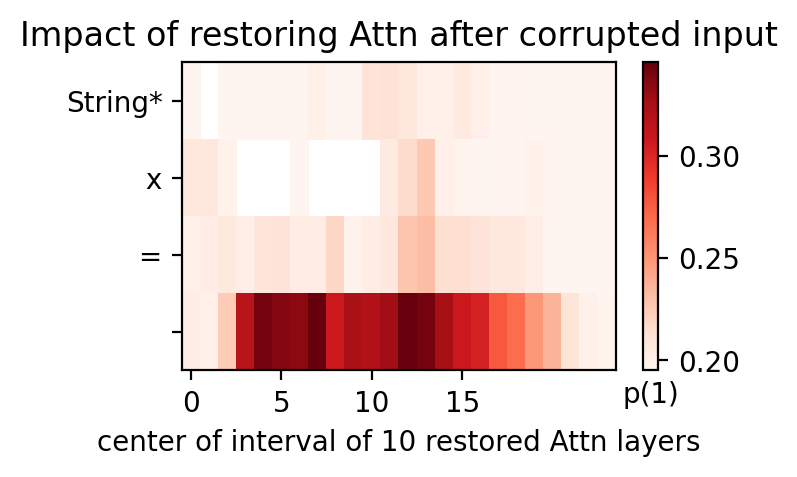

In [9]:
plot_all_flow(mt, "String x = ", noise=noise_level)

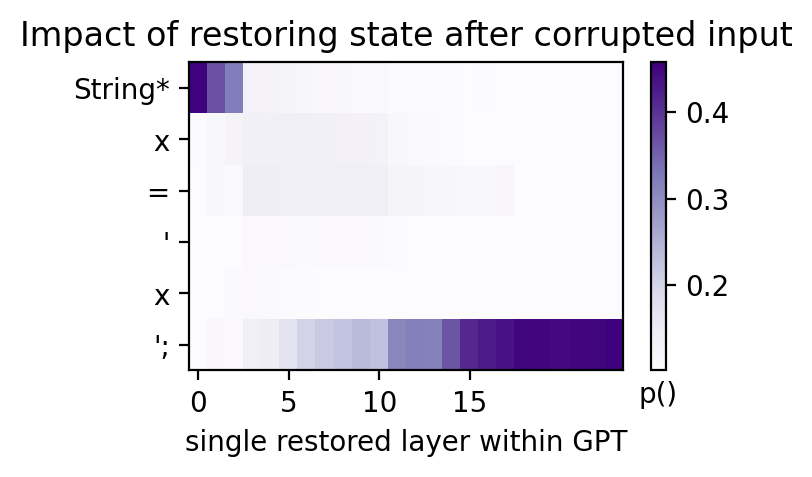

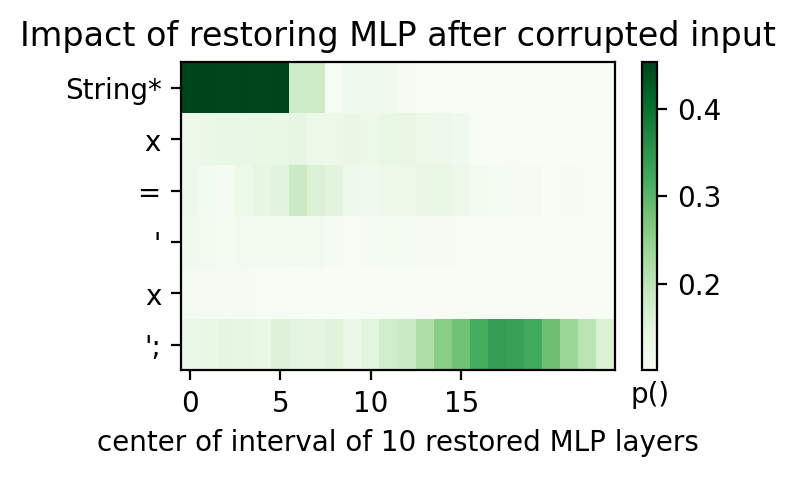

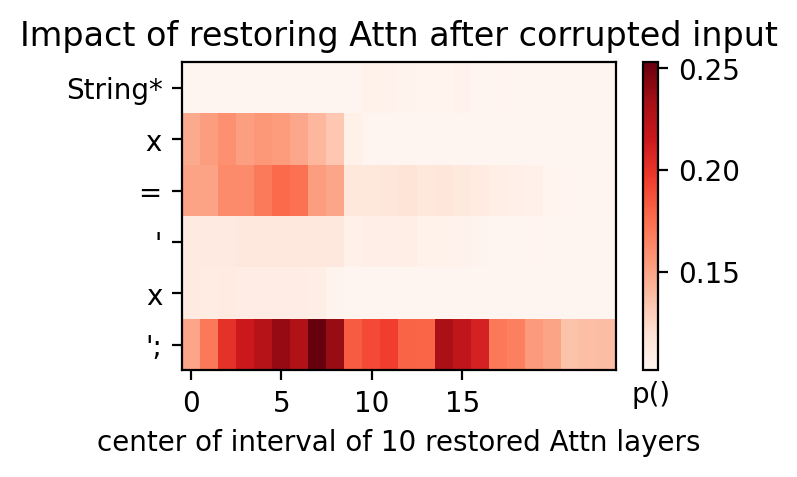

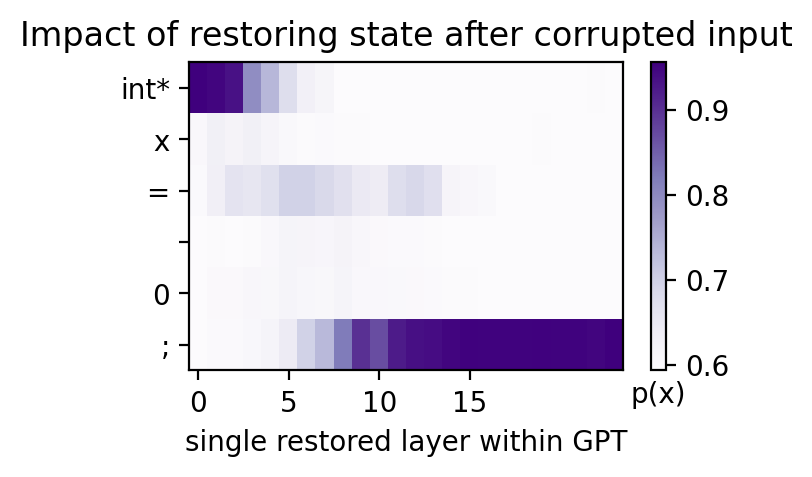

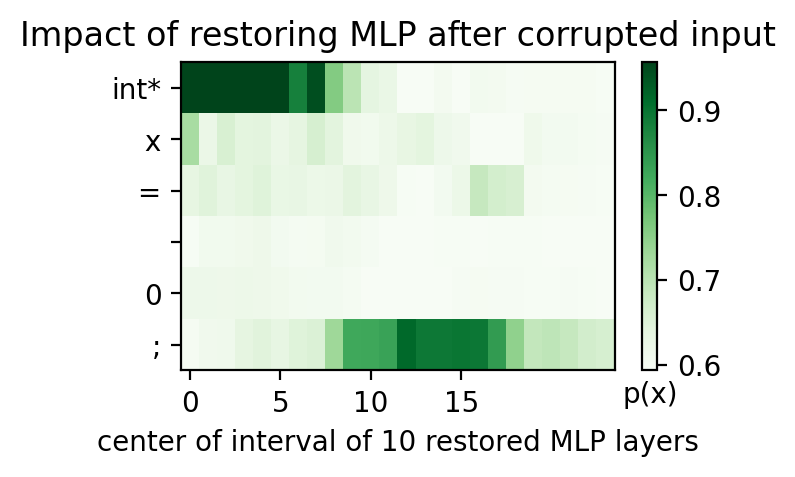

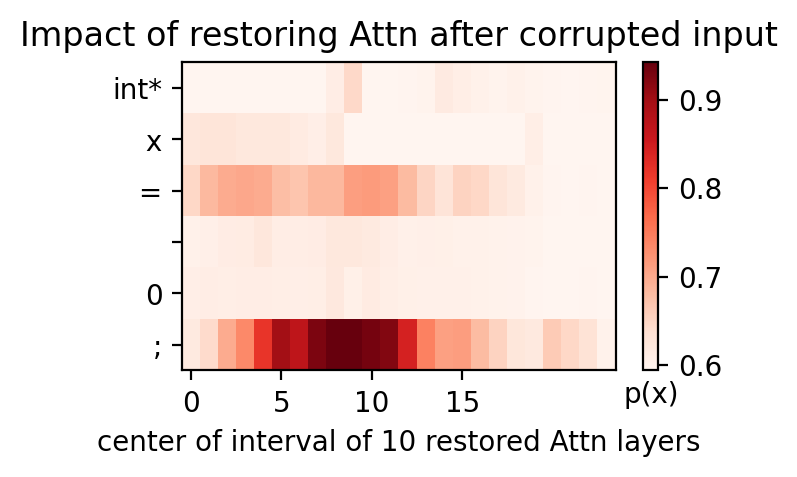

In [10]:
for knowledge in knowns[:5]:
    plot_all_flow(mt, knowledge["prompt"], knowledge["subject"], noise=noise_level)